In [106]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats.stats import pearsonr   
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as ols

## Считываем данные

In [107]:
df = pd.read_csv('income_dataset.csv')

In [108]:
df.head()

,monthly_income_amt,education_level_cd,gender_cd,age,marital_status_cd,job_position_cd,car_own_flg,work_exp_cd,accnt_cnt,credit_amt_max,credit_card_sum,accnt_open_due_cnt,wrst_delqbalance_max,cred_av
0,30.0,UGR,F,21,UNM,WRK,0,0,1.0,62.43,0.00,0.0,0.00,62.430
1,48.0,SCH,M,36,UNM,BIS,0,0,9.0,128.00,22.08,0.0,0.00,33.098
2,30.0,GRD,M,37,MAR,SPC,0,1,28.0,333.00,153.00,0.0,8.86,75.387
3,11.0,SCH,F,66,CIV,PNA,0,0,2.0,52.90,0.00,0.0,0.00,51.450
4,30.0,GRD,F,46,UNM,UMN,0,2,7.0,166.50,210.50,0.0,0.00,54.583


## Задание

Усилить модель линейной регрессии, построенную на лекции, за счет добавления новых переменных. 

Целевая переменная - месячный доход monthly_income_amt.

In [109]:
test = df[10000:]
train = df[:10000]

###  Количественные признаки
Проверим три количественных признака, которые не были затронуты в лекции
* credit_card_sum
* wrst_delqbalance_max
* cred_av

Убираем выбросы

In [110]:
train = train.assign(credit_card_sum = train['credit_card_sum'].clip(1, np.percentile(train['credit_card_sum'], 99)),
                     wrst_delqbalance_max = train['wrst_delqbalance_max'].clip(1, np.percentile(train['wrst_delqbalance_max'], 99)),
                     cred_av = train['cred_av'].clip(1, np.percentile(train['cred_av'], 99)),
                     monthly_income_amt = train['monthly_income_amt'].clip(1, np.percentile(train['monthly_income_amt'], 99)),
                    )

In [111]:
train.describe()

,monthly_income_amt,age,car_own_flg,work_exp_cd,accnt_cnt,credit_amt_max,credit_card_sum,accnt_open_due_cnt,wrst_delqbalance_max,cred_av
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,37.390136,37.415300,0.133900,0.626600,6.870600,353.170971,37.414012,0.117300,11.046667,107.628773
std,24.319135,11.681022,0.340562,0.783986,7.428901,1802.153169,71.909099,0.354617,31.155866,192.204430
min,1.000000,18.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2.500000
25%,22.500000,28.000000,0.000000,0.000000,2.000000,30.000000,1.000000,0.000000,1.000000,18.636500
50%,30.000000,35.000000,0.000000,0.000000,5.000000,95.025000,1.000000,0.000000,1.786000,41.360000
75%,45.000000,45.000000,0.000000,1.000000,9.000000,315.407500,43.000000,0.000000,6.807500,105.491750
max,150.000000,72.000000,1.000000,2.000000,136.000000,115753.320000,408.901000,4.000000,239.693760,1296.654640


Проверяем линейность зависимости целевой переменной от credit_card_sum путем отрисовки простой регрессии 

In [112]:
def check_if_linear(data, feature_name, target_name):
    #разбивка данных по бакетам для лучшей визуализации
    #не отражается на итоговом датасете
    data = data[[feature_name, target_name]].copy()
    data['bucket'] = np.floor(data[feature_name].rank(pct = True) * 100)
    data = data.groupby('bucket').mean()
    
    #проверка простой линейной регрессии с одной переменной
    regr_check = LinearRegression()
    regr_check.fit(data[feature_name].to_numpy().reshape(-1,1),data[target_name])
    pred = regr_check.predict(data[feature_name].to_numpy().reshape(-1,1))
    plt.plot(data[feature_name], pred)
    plt.grid()
    plt.scatter(data[feature_name], data[target_name])
    plt.title('Проверка линейности зависимости {} и {} '.format(feature_name, target_name))
    plt.xlabel(feature_name)
    plt.ylabel(target_name)


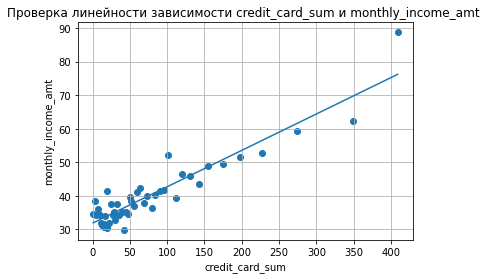

In [113]:
check_if_linear(train, 'credit_card_sum', 'monthly_income_amt')

Признак credit_card_sum и целевая переменная связаны линейной зависимостью, дополнительные преобразования не требуются 

Проверка wrst_delqbalance_max на линейность

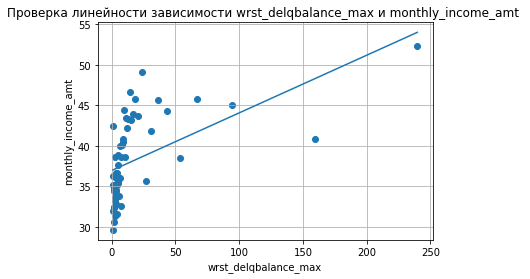

In [114]:
check_if_linear(train, 'wrst_delqbalance_max', 'monthly_income_amt')

Данную зависимость попробуем сделать более линейной, применив логарифм

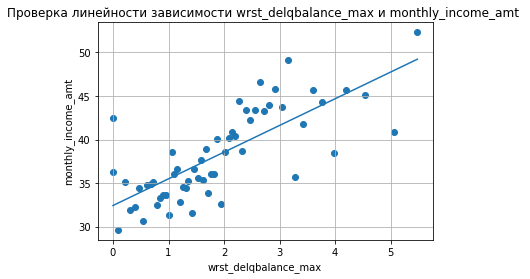

In [115]:
train = train.assign(wrst_delqbalance_max = np.log(train['wrst_delqbalance_max']))
check_if_linear(train, 'wrst_delqbalance_max', 'monthly_income_amt')

После преобразований линейная зависимость прослеживается лучше

Проверяем признак cred_av

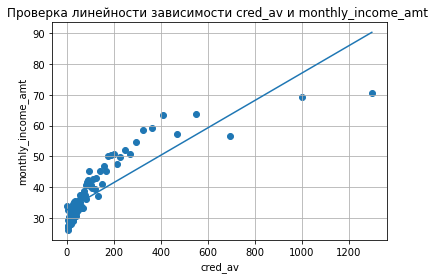

In [116]:
check_if_linear(train, 'cred_av', 'monthly_income_amt')

Видно явную нелинейную связь - можем разделить этот признак на два, для которых наблюдается линейность. 

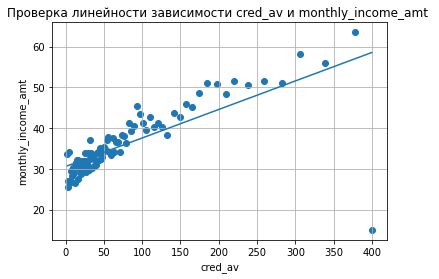

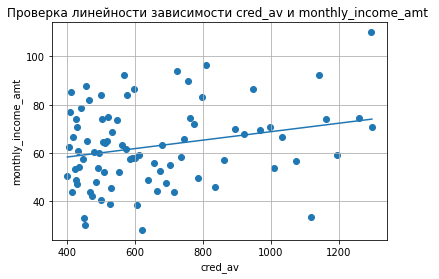

In [117]:
check_if_linear(train[train.cred_av < 400], 'cred_av', 'monthly_income_amt')
plt.figure()
check_if_linear(train[train.cred_av >= 400], 'cred_av', 'monthly_income_amt')
train['cred_av_low'] = np.where(train['cred_av'] < 400, train['cred_av'], 400)
train['cred_av_high'] = np.where(train['cred_av'] >= 400, train['cred_av'], 400)
#присвоили пограничные значения, получили два новых признака

Для трех рассмотренных количественных признаков проверим гомоскедастичность

In [118]:
def check_homoscedacity(data, feature_name, target_name):
    data = data[[feature_name, target_name]].copy()
    data['bucket'] = np.floor(data[feature_name].rank(pct = True) * 500)
    data = data.groupby('bucket').mean()

    check_reg = LinearRegression()
    check_reg.fit(data[feature_name].to_numpy().reshape(-1,1),data[target_name])
    pred = check_reg.predict(data[feature_name].to_numpy().reshape(-1,1))

    plt.scatter(pred, data[target_name] - pred)
    plt.grid()
    plt.title('Проверка гомоскедастичности признака ' + feature_name)
    plt.xlabel('predicted')
    plt.ylabel('residuals')


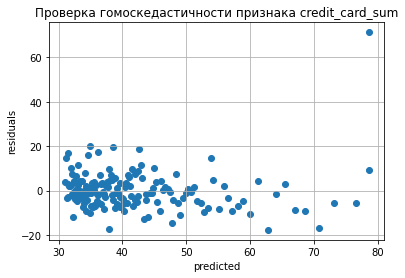

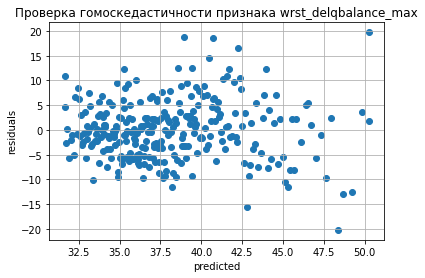

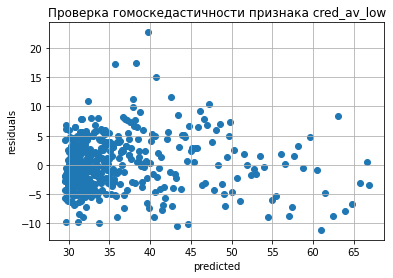

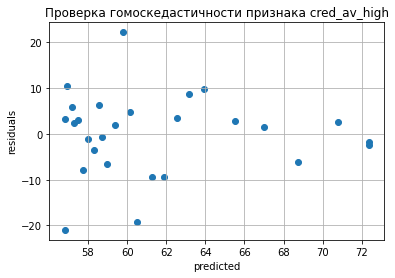

In [119]:
check_homoscedacity(train, 'credit_card_sum', 'monthly_income_amt')
plt.figure()
check_homoscedacity(train, 'wrst_delqbalance_max', 'monthly_income_amt')
plt.figure()
check_homoscedacity(train, 'cred_av_low', 'monthly_income_amt')
plt.figure()
check_homoscedacity(train, 'cred_av_high', 'monthly_income_amt')

Для рассмотренных признаков в целом наблюдается постоянство остатков

Проверка на нормальность: коэффициенты линейной регрессии подбираются на трех количественных признаках, смотрим на распределение её ошибок


In [120]:
features = ['credit_card_sum','cred_av_low', 'cred_av_high','wrst_delqbalance_max']

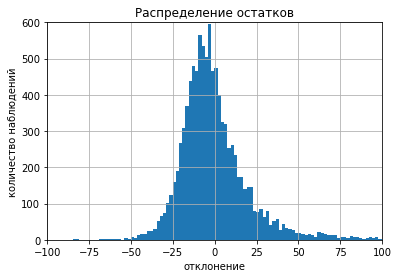

In [121]:
model = LinearRegression()
model.fit(np.array(train[features]),train['monthly_income_amt'])
resids = train['monthly_income_amt'] - (model.predict(train[features]))
plt.hist(resids, bins='auto')[2]
plt.xlabel('отклонение')
plt.ylabel('количество наблюдений')
plt.title('Распределение остатков')
plt.axis([-100, 100, 0, 600])
plt.grid(True)
plt.show()

Распределение ошибок для модели, построенной по данным трем признакам, похоже на нормальное

Проверка признаков на скоррелированность

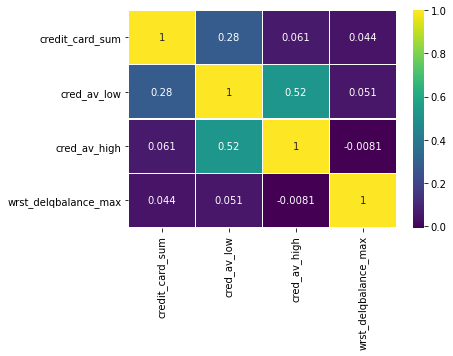

In [122]:
pcorr = pd.DataFrame 
pcorr = []
for f1 in features:
    for f2 in features:
        pcorr.append((f1,f2,pearsonr(train[f1],train[f2])))
        
cor = train.loc[:,features].corr(method='pearson')
cm=plt.cm.viridis
sns.heatmap(cor,cmap=cm,linewidths=0.1,linecolor='white',annot=True)
plt.show()

Для данных признаков значения коэффициентов корреляции низкие (ниже 0.4-0.5, исключая cred_av_low и cred_av_high), все рассмотренные признаки можно оставить в модели. 

Таким образом, признаки 
* credit_card_sum
* cred_av
* wrst_delqbalance_max  

подготовлены и могут быть применены для построения линейной модели регрессии.

### Категориальные признаки
Для применения категориальных признаков в модели линейной регресии необходимо выполнить кодирование, преобразовав таким образом категориальные признаки в количественные. Здесь можно рассмотреть label encoding и one-hot encoding. Предпочтительнее выбирать one-hot encoding, т.к. в случае label encoding уникальным значениям признака "присваиваются" порядковые номера, из-за этого одни значения будут больше других, что может внести неточность в модель

Здесь и далее для удобства проверки мы будем создавать новый датафрейм для каждого кодированного признака. Для one-hot encoding будем пользоваться методом get_dummies из библиотеки pandas

Рассмотрим work_exp_cd

In [123]:
target = train.monthly_income_amt

In [124]:
dummy_train = pd.get_dummies(train, prefix = ['work_exp_cd', 'marital_status_cd', 'job_position_cd'], columns=['work_exp_cd', 'marital_status_cd', 'job_position_cd'])

Обучим модель линейной регрессии на данном кодированном признаке и посмотрим на значение r_2

In [125]:
X = dummy_train[['work_exp_cd_0', 'work_exp_cd_1', 'work_exp_cd_2']]
reg = LinearRegression().fit(X, target)
print('значение r_2 =', reg.score(X, target))

значение r_2 = 0.0025879981364990146


Значение r_2 здесь получается низкое, сложно сказать о наличии линейной зависимости между work_exp_cd и целевой переменной

Аналогичным образом рассмотрим признак marital_status_cd

In [126]:
X = dummy_train[['marital_status_cd_CIV', 'marital_status_cd_DIV', 'marital_status_cd_MAR', 'marital_status_cd_UNM', 'marital_status_cd_WID']]
reg = LinearRegression().fit(X, target)
print('значение r_2 =', reg.score(X, target))

значение r_2 = 0.010657839827352134


И job_position_cd

In [127]:
names = ['job_position_cd_ATP', 'job_position_cd_BIS',
        'job_position_cd_BIU', 'job_position_cd_DIR',
        'job_position_cd_HSK', 'job_position_cd_INP',
        'job_position_cd_NOR', 'job_position_cd_PNA',
        'job_position_cd_PNI', 'job_position_cd_PNS',
        'job_position_cd_PNV', 'job_position_cd_SPC',
        'job_position_cd_UMN', 'job_position_cd_UNK',
        'job_position_cd_WOI', 'job_position_cd_WRK',
        'job_position_cd_WRP'] 

In [128]:
X = dummy_train[names]
reg = LinearRegression().fit(X, target)
print('значение r_2 =', reg.score(X, target))

значение r_2 = 0.15757858554987103


Из трех рассмотренных категориальных признаков линейная регрессия на признаке job_position_cd показывает наибольшее значение r_2. Попробуем добавить этот признак в финальную модель.

Таким образом, из шести рассмотренных признаков следующие можно использовать для построения модели линейной регрессии
* credit_card_sum
* cred_av (это признак "поделен" на линейные участки)
* wrst_delqbalance_max (для этого признака выполнена линеаризация через логарифм)
* job_position_cd (для этого признака выполено one-hot кодирование)

### Модель линейной регрессии с выбранными признаками

"Собираем" итоговый обучающий набор

In [129]:
train_final = dummy_train
train_final.head()

,monthly_income_amt,education_level_cd,gender_cd,age,car_own_flg,accnt_cnt,credit_amt_max,credit_card_sum,accnt_open_due_cnt,wrst_delqbalance_max,...,job_position_cd_PNA,job_position_cd_PNI,job_position_cd_PNS,job_position_cd_PNV,job_position_cd_SPC,job_position_cd_UMN,job_position_cd_UNK,job_position_cd_WOI,job_position_cd_WRK,job_position_cd_WRP
0,30.0,UGR,F,21,0,1.0,62.43,1.00,0.0,0.000000,...,0,0,0,0,0,0,0,0,1,0
1,48.0,SCH,M,36,0,9.0,128.00,22.08,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,30.0,GRD,M,37,0,28.0,333.00,153.00,0.0,2.181547,...,0,0,0,0,1,0,0,0,0,0
3,11.0,SCH,F,66,0,2.0,52.90,1.00,0.0,0.000000,...,1,0,0,0,0,0,0,0,0,0
4,30.0,GRD,F,46,0,7.0,166.50,210.50,0.0,0.000000,...,0,0,0,0,0,1,0,0,0,0


In [130]:
model = ols.ols(formula = 'monthly_income_amt ~ credit_card_sum + cred_av_low + cred_av_high + wrst_delqbalance_max + job_position_cd_ATP + job_position_cd_BIS + job_position_cd_BIU + job_position_cd_DIR + job_position_cd_HSK + job_position_cd_INP + job_position_cd_NOR + job_position_cd_PNA + job_position_cd_PNI + job_position_cd_PNS + job_position_cd_PNV + job_position_cd_SPC + job_position_cd_UMN + job_position_cd_UNK + job_position_cd_WOI + job_position_cd_WRK + job_position_cd_WRP' , data = train_final)

result_model = model.fit()
print('r2 на обучающем наборе = ' + str(round(result_model.rsquared,3)))

r2 на обучающем наборе = 0.296


In [131]:
pd.DataFrame(data = list(zip(result_model.pvalues.index,[round(i,4) for i in result_model.pvalues.values])),columns=['feature','p_value']).set_index('feature')

,p_value
feature,
Intercept,0.0000
credit_card_sum,0.0000
cred_av_low,0.0000
cred_av_high,0.0000
wrst_delqbalance_max,0.0000
job_position_cd_ATP,0.0121
job_position_cd_BIS,0.0000
job_position_cd_BIU,0.0000
job_position_cd_DIR,0.0000


По значениям p-value можем сказать, что признаки значимы (job_position_cd_... не рассматриваем, т.к. это разные уровни одной и той же категориальной переменной, убиарть какие-то из этих значений нежелательно (зависит от задачи/датасета))

In [132]:
feature = ['credit_card_sum','cred_av_low','cred_av_high',
           'wrst_delqbalance_max' ,'job_position_cd_ATP',
           'job_position_cd_BIS', 'job_position_cd_BIU',
           'job_position_cd_DIR', 'job_position_cd_HSK',
           'job_position_cd_INP', 'job_position_cd_NOR',
           'job_position_cd_PNA', 'job_position_cd_PNI',
           'job_position_cd_PNS', 'job_position_cd_PNV',
           'job_position_cd_SPC', 'job_position_cd_UMN', 
           'job_position_cd_UNK', 'job_position_cd_WOI',
           'job_position_cd_WRK', 'job_position_cd_WRP']  

Необходимо выполнить one-hot кодирование и на тестовом наборе для job_position_cd + всю остальную подготовку (логарифм для wrst_delqbalance_max, удаление выбросов)

In [133]:
test_final = test.copy()
test_final = test_final.assign(credit_card_sum = test_final.credit_card_sum.clip(1 ,np.percentile(test_final.credit_card_sum, 99)),
                               wrst_delqbalance_max = test_final.wrst_delqbalance_max.clip(1 ,np.percentile(test_final.wrst_delqbalance_max, 99)),
                               cred_av = test_final.cred_av.clip(1 ,np.percentile(test_final.cred_av, 99)),
                               monthly_income_amt = test_final.monthly_income_amt.clip(1 ,np.percentile(test_final.monthly_income_amt, 99)))


test_final = pd.get_dummies(test_final, prefix = ['job_position_cd'], columns=['job_position_cd'])
test_final = (test_final.assign(wrst_delqbalance_max = np.log(test_final.wrst_delqbalance_max)))

test_final['cred_av_low'] = np.where(test_final['cred_av'] < 400, test_final['cred_av'], 400)
test_final['cred_av_high'] = np.where(test_final['cred_av'] >= 400, test_final['cred_av'], 400)

test_final.head()

,monthly_income_amt,education_level_cd,gender_cd,age,marital_status_cd,car_own_flg,work_exp_cd,accnt_cnt,credit_amt_max,credit_card_sum,...,job_position_cd_PNS,job_position_cd_PNV,job_position_cd_SPC,job_position_cd_UMN,job_position_cd_UNK,job_position_cd_WOI,job_position_cd_WRK,job_position_cd_WRP,cred_av_low,cred_av_high
10000,82.5,SCH,F,34,CIV,0,0,3.0,5.15,1.0000,...,0,0,0,0,0,0,0,0,4.227,400.0
10001,25.0,SCH,M,25,CIV,0,0,2.0,13.49,1.0000,...,0,0,0,0,0,0,1,0,13.220,400.0
10002,100.0,SCH,M,34,MAR,1,2,23.0,551.20,346.0000,...,0,0,1,0,0,0,0,0,113.238,400.0
10003,48.0,GRD,M,28,UNM,0,1,8.0,22.76,1.0000,...,0,0,1,0,0,0,0,0,10.417,400.0
10004,170.0,GRD,F,62,WID,0,0,12.0,1000.00,440.1633,...,0,0,0,0,0,0,0,0,396.056,400.0


In [134]:
y_true = test_final['monthly_income_amt']
y_pred = result_model.predict(test_final[feature])

In [135]:
from sklearn.metrics import r2_score
r2_score(y_true, y_pred)

0.3067123698659614

Значение r_2 на тестовом наборе составило 0.3

###  Усиление модели с лекции
Добавим выбранные признаки в модель, рассмотренную на лекции

In [136]:
test2 = df[10000:]
train2 = df[:10000]

Предварительная подготовка признаков

In [137]:
#Обработка признаков, рассмотренных на лекции
#(...)

#Обработка и добавление признаков, полученных в ходе домашней работы
train2 = train2.assign(credit_card_sum = train2.credit_card_sum.clip(1 ,np.percentile(train2.credit_card_sum, 99)),
                               wrst_delqbalance_max = train2.wrst_delqbalance_max.clip(1 ,np.percentile(train2.wrst_delqbalance_max, 99)),
                               cred_av = train2.cred_av.clip(1 ,np.percentile(train2.cred_av, 99)),
                               monthly_income_amt = train2.monthly_income_amt.clip(1 ,np.percentile(train2.monthly_income_amt, 99)))


train2 = pd.get_dummies(train2, prefix = ['job_position_cd'], columns=['job_position_cd'])
train2 = (train2.assign(wrst_delqbalance_max = np.log(train2.wrst_delqbalance_max)))

#Разделяем признак cred_av на два
train2['cred_av_low'] = np.where(train2['cred_av'] < 400, train2['cred_av'], 400)
train2['cred_av_high'] = np.where(train2['cred_av'] >= 400, train2['cred_av'], 400)

#итоговый обучающий набор
train2_final = train2.copy()

In [138]:
model = ols.ols(formula = 'monthly_income_amt ~ accnt_cnt + credit_amt_max + low_age + high_age + gender_cd + education_level_cd + cred_av_low + cred_av_high + credit_card_sum + wrst_delqbalance_max + job_position_cd_ATP + job_position_cd_BIS + job_position_cd_BIU + job_position_cd_DIR + job_position_cd_HSK + job_position_cd_INP + job_position_cd_NOR + job_position_cd_PNA + job_position_cd_PNI + job_position_cd_PNS + job_position_cd_PNV + job_position_cd_SPC + job_position_cd_UMN + job_position_cd_UNK + job_position_cd_WOI + job_position_cd_WRK + job_position_cd_WRP' , data = train2_final)

res_full = model.fit()
print('r2 на обучающем наборе = ' + str(round(res_full.rsquared,3)))

r2 на обучающем наборе = 0.35


За счет добавления новых признаков удалось повысить качество модели на трейне. Протестируем новую модель на тестовом наборе

Готовим тестовый набор

In [139]:
#Обработка признаков, рассмотренных на лекции
#(...)

#Обработка и добавление признаков, полученных в ходе домашней работы
test2 = test2.assign(credit_card_sum = test2.credit_card_sum.clip(1 ,np.percentile(test2.credit_card_sum, 99)),
                               wrst_delqbalance_max = test2.wrst_delqbalance_max.clip(1 ,np.percentile(test2.wrst_delqbalance_max, 99)),
                               cred_av = test2.cred_av.clip(1 ,np.percentile(test2.cred_av, 99)),
                               monthly_income_amt = test2.monthly_income_amt.clip(1 ,np.percentile(test2.monthly_income_amt, 99)))


test2 = pd.get_dummies(test2, prefix = ['job_position_cd'], columns=['job_position_cd'])
test2 = (test2.assign(wrst_delqbalance_max = np.log(test2.wrst_delqbalance_max)))

#Разделяем признак cred_av на два
test2['cred_av_low'] = np.where(test2['cred_av'] < 400, test2['cred_av'], 400)
test2['cred_av_high'] = np.where(test2['cred_av'] >= 400, test2['cred_av'], 400)


#итоговый обучающий набор
test2_final = test2.copy()

In [140]:
y_true2 = test2_final['monthly_income_amt']
features_final = ['accnt_cnt','credit_amt_max','low_age','high_age','gender_cd','education_level_cd','cred_av_low','cred_av_high','credit_card_sum','wrst_delqbalance_max','job_position_cd_ATP','job_position_cd_BIS',
                  'job_position_cd_BIU','job_position_cd_DIR','job_position_cd_HSK','job_position_cd_INP','job_position_cd_NOR','job_position_cd_PNA','job_position_cd_PNI','job_position_cd_PNS',
                  'job_position_cd_PNV','job_position_cd_SPC','job_position_cd_UMN','job_position_cd_UNK','job_position_cd_WOI','job_position_cd_WRK','job_position_cd_WRP']

y_pred2 = res_full.predict(test2_final[features_final])

In [141]:
r2_score(y_true2, y_pred2)

0.3406518896969767

За счет добавления новых признаков удалось повысить точность на тестовом наборе (r_2 = 0.34 по сравнению с 0.19 с лекции), тем не менее этот результат недостаточно качественный (хорошими были бы значения r_2 более 0.6)